In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

rng = np.random.default_rng()

In [2]:
def linlog_bins(data, numbins=10):
    """
    Logarithmic binning algorithm for discrete data. 
    Return bin edges that are linear in the range [1, logmin] 
    and logarithmic in the range [logmin, maxval + 1].
    logmin is chosen such that the widths of the logarithmic bins are
    at least 1.5.
    """
    maxval = np.max(data)
    for logmin in range(1, maxval):
        ratio = np.exp((np.log(maxval + 1) - np.log(logmin)) / (numbins - logmin + 2))
        if logmin * ratio > logmin + 1.5:
            break
    # Construct the bins
    bins = np.concatenate((np.arange(1, logmin), 
        np.ceil(np.geomspace(logmin, maxval + 1, numbins - logmin + 2)))) - 0.5
    return bins

# Implementing the Barabási–Albert model

The Barabási-Albert (BA) model is a model of network growth where new nodes enter the network one by one, creating links to existing nodes with a probability linearly proportional to their degree. The steps required for generating a BA network with $N$ nodes are as follows:

- Create a small seed network that has at least $m$ nodes, where $m$ is the number of links a new node creates to existing nodes.  In this exercise, use a 4-clique as the seed network.
- Add new nodes to the network until your network has $N$ nodes, such that each entering node has $m$ links to existing nodes, chosen with a probability proportional to their degrees.

In this exercise, we will implement the model and investigate the networks it generates. This notebook covers most of the plotting and binning required in this exercise, which lets you focus only on the actual implementation of the model.

When you're done, answer the questions in the MyCourses quiz.

## a) Implementing the Barabási-Albert model 
Implement a Python function for generating Barabási-Albert networks. Do not use the readymade networkx function, but implement your preferential attachment algorithm yourself following the template below. Then generate a network with $N=250$ and the value of $m$ from your MyCourses quiz (starting from a 4-clique seed network). Print the maximum degree and the number of edges in your network to answer the questions in the MyCourses quiz.

**Hints**: 
- In general, the seed network can be anything, *e.g.* a clique of size $m+1$, as long as it has enough nodes for the first incoming node to attach to with $m$ links. In this exercise, *use a 4-clique*.
- The easiest way of picking nodes with probability proportional to their degree is to use the `p` keyword in function `rng.choice` to assign a probability of selection to each element and the `size` keyword to indicate how many nodes to sample. Remember to set the `replace` keyword to `False` to ensure you don't draw any node more than once.

In [22]:
def ba_network(N, m, seed_net_size, rng):
    # Generate the seed network (a clique of size seed_net_size)
    G = nx.complete_graph(seed_net_size)

    # TODO: Grow the network by adding nodes one by one until it reaches size N
    # YOUR CODE HERE
    for i in range(seed_net_size, N):
        G.add_node(i)

        total_degree = 2 * G.number_of_edges()

        # Add m edges to the new node
        connect_to = rng.choice(list(G.nodes), p=[deg/total_degree for node, deg in G.degree()], size = m, replace = False)
        for j in connect_to:
            G.add_edge(i, j)
            
    return G

In [23]:
net = ba_network(N=250, m=3, seed_net_size=4, rng=rng) # REPLACE m with the value given in your MyCourses quiz
nodes = net.nodes()
degrees_dict = nx.degree(net)
degrees = [degrees_dict[node] for node in nodes]

print("The maximum degree is: ", max(degrees))
print("The total number of edges is: ", len(net.edges()))


The maximum degree is:  70
The total number of edges is:  744


## b) Network visualization

Next, visualize the network using NetworkX, and compare the visualization to the alternatives shown on your MyCourses quiz. Which one resembles your network the most?


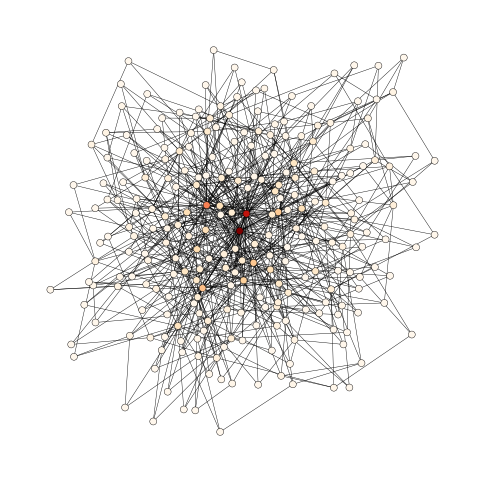

In [25]:
fig_vis, ax_vis = plt.subplots(figsize=(6, 6))
nx.draw(
    net, ax=ax_vis, node_size=25, node_color=degrees, cmap='OrRd',
    vmin=np.min(degrees), vmax=np.max(degrees), width=0.3, linewidths=0.3, edgecolors='black')

# Save the figure to current directory
figure_filename = 'BA_visualized.pdf'
fig_vis.savefig(figure_filename)

### c) The degree distribution
Generate a new network using parameters $N=10^4$ with $m=3$ and plot the logarithmically binned probability density function for degree, $P(k)$ on double logarithmic axes. Compare your result with the theoretical prediction of 
$$
P(k)=2m\left(m+1\right)/\left[k\left(k+1\right)\left(k+2\right)\right].
$$
To do this, plot the experimental and theoretical distributions on the same axes.

**Hints**:
- Generating the results should take less than a minute. If your code takes too long to run, there are probably ways to improve its efficiency. Try to be efficient when picking nodes as link targets.
- The code for plotting the binned degree distribution with logarithmic bins is provided in this notebook.

In [26]:
def theory(k, m):
    return 2*m*(m+1)/(k*(k+1)*(k+2))

In [27]:
net = ba_network(N=10000, m=3, seed_net_size=4, rng=rng)

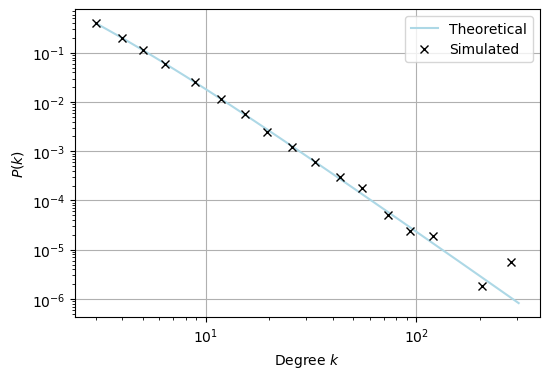

In [28]:
# Get the degrees of all nodes
degrees = []
degrees = [deg for _, deg in nx.degree(net)]
# Bin the degrees logarithmically and compute the distribution
bins = linlog_bins(degrees, numbins=20)
pk, bin_edges = np.histogram(degrees, bins=bins, density=True)
# Get the bin centers using scipy.stats.binned_statistic
bincenters, _, _ = scipy.stats.binned_statistic(degrees, degrees, statistic='mean', bins=bins)

# Get the theoretical prediction
k_theory = np.arange(np.min(degrees), np.max(degrees))
pk_theory = theory(k_theory, m=3)

# Plot the results
fig_dist, ax_dist = plt.subplots(figsize=(6, 4))
ax_dist.plot(k_theory, pk_theory, color='lightblue', label='Theoretical')
ax_dist.plot(bincenters, pk, 'x', color='black', label='Simulated')
ax_dist.set_xlabel('Degree $k$')
ax_dist.set_ylabel('$P(k)$')
ax_dist.set_xscale('log')
ax_dist.set_yscale('log')
ax_dist.legend()
ax_dist.grid()

In [29]:
# Save the figure to current directory
figure_filename = 'BA_degree_distribution.pdf'
fig_dist.savefig(figure_filename)